## Multinomial Choice Models and the Indepdence of Irrelevant Alternatives

In [1]:
import arviz as az
import pandas as pd

%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../../../..")

from pymc_marketing.customer_choice.mnl_logit import MNLogit

In [2]:
df = pd.read_csv("../../../../data/choice_wide_heating.csv")
df

,idcase,depvar,ic_gc,ic_gr,ic_ec,ic_er,ic_hp,oc_gc,oc_gr,oc_ec,oc_er,oc_hp,income,agehed,rooms,region
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,gc,766.39,877.71,751.59,869.78,942.70,142.61,136.21,474.48,420.65,203.00,6,20,4,mountn
896,897,gc,1128.50,1167.80,1047.60,1292.60,1297.10,207.40,213.77,705.36,551.61,243.76,7,45,7,scostl
897,898,gc,787.10,1055.20,842.79,1041.30,1064.80,175.05,141.63,478.86,448.61,254.51,5,60,7,scostl
898,899,gc,860.56,1081.30,799.76,1123.20,1218.20,211.04,151.31,495.20,401.56,246.48,5,50,6,scostl


In [3]:
utility_formulas = [
    "gc ~ ic_gc + oc_gc | income + rooms + agehed",
    "gr ~ ic_gr + oc_gr | income + rooms + agehed",
    "ec ~ ic_ec + oc_ec | income + rooms + agehed",
    "er ~ ic_er + oc_er | income + rooms + agehed",
    "hp ~ ic_hp + oc_hp | income + rooms + agehed",
]

mnl = MNLogit(df, utility_formulas, "depvar", covariates=["ic", "oc"])
mnl

In [4]:
mnl.sample()

Sampling: [alphas_, betas, betas_fixed_, likelihood]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas_, betas, betas_fixed_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Sampling: [likelihood]


Output()

In [5]:
az.summary(mnl.idata, var_names=["alphas", "betas", "betas_fixed"])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas[gc],1.399,0.724,0.015,2.733,0.021,0.013,1177.0,1674.0,1.0
alphas[gr],0.380,0.818,-1.114,1.944,0.023,0.014,1303.0,2131.0,1.0
alphas[ec],0.833,1.014,-0.913,2.908,0.026,0.017,1491.0,2351.0,1.0
alphas[er],2.357,0.919,0.705,4.130,0.023,0.014,1563.0,2280.0,1.0
alphas[hp],0.000,0.000,0.000,0.000,0.000,NaN,4000.0,4000.0,NaN
betas[ic],-0.002,0.001,-0.003,-0.000,0.000,0.000,4290.0,3067.0,1.0
betas[oc],-0.007,0.002,-0.010,-0.004,0.000,0.000,3448.0,3134.0,1.0
"betas_fixed[gc, income]",-0.059,0.087,-0.220,0.107,0.002,0.001,1676.0,1950.0,1.0
"betas_fixed[gc, rooms]",-0.004,0.082,-0.163,0.147,0.002,0.001,1842.0,1787.0,1.0
"betas_fixed[gc, agehed]",0.015,0.010,-0.004,0.035,0.000,0.000,1415.0,2058.0,1.0


### New Pricing Intervention


In [6]:
new_policy_df = df.copy()
new_policy_df[["ic_ec", "ic_er"]] = new_policy_df[["ic_ec", "ic_er"]] * 1.5

idata_new_policy = mnl.apply_intervention(new_choice_df=new_policy_df)

Sampling: [likelihood]


Output()

In [7]:
change_df = mnl.calculate_share_change(mnl.idata, mnl.intervention_idata)
change_df

,policy_share,new_policy_share,relative_change
product,,,
gc,0.636764,0.689480,0.082786
gr,0.143458,0.155397,0.083226
ec,0.070980,0.043253,-0.390625
er,0.093201,0.051427,-0.448219
hp,0.055596,0.060443,0.087174


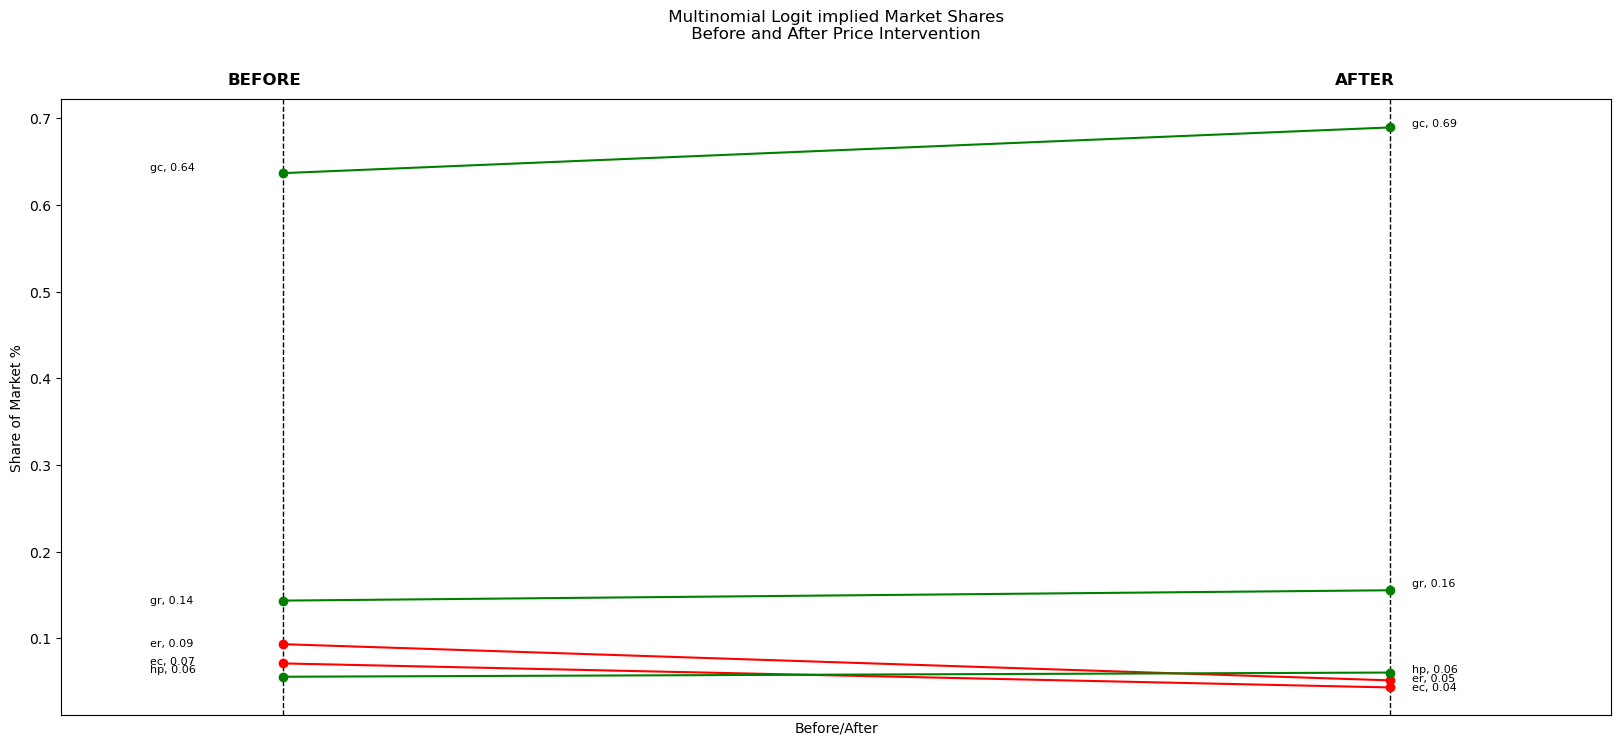

In [8]:
fig = mnl.make_change_plot(change_df, figsize=(20, 8))

### Market Product Intervention


In [9]:
new_policy_df = df.copy()
new_policy_df = new_policy_df[new_policy_df["depvar"] != "hp"]

new_utility_formulas = [
    "gc ~ ic_gc + oc_gc | income + rooms + agehed",
    "gr ~ ic_gr + oc_gr | income + rooms + agehed",
    "ec ~ ic_ec + oc_ec | income + rooms + agehed",
    "er ~ ic_er + oc_er | income + rooms + agehed",
    #'hp ~ ic_hp + oc_hp | income + rooms + agehed'
]

idata_new_policy = mnl.apply_intervention(
    new_choice_df=new_policy_df, new_utility_equations=new_utility_formulas
)

Sampling: [alphas_, betas, betas_fixed_, likelihood]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas_, betas, betas_fixed_]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 102 seconds.
Sampling: [likelihood]


Output()

In [10]:
change_df = mnl.calculate_share_change(mnl.idata, mnl.intervention_idata)
change_df

,policy_share,new_policy_share,relative_change
product,,,
gc,0.636764,0.674460,0.059199
gr,0.143458,0.151770,0.057944
ec,0.070980,0.075343,0.061466
er,0.093201,0.098427,0.056065
hp,0.055596,0.000000,-1.000000


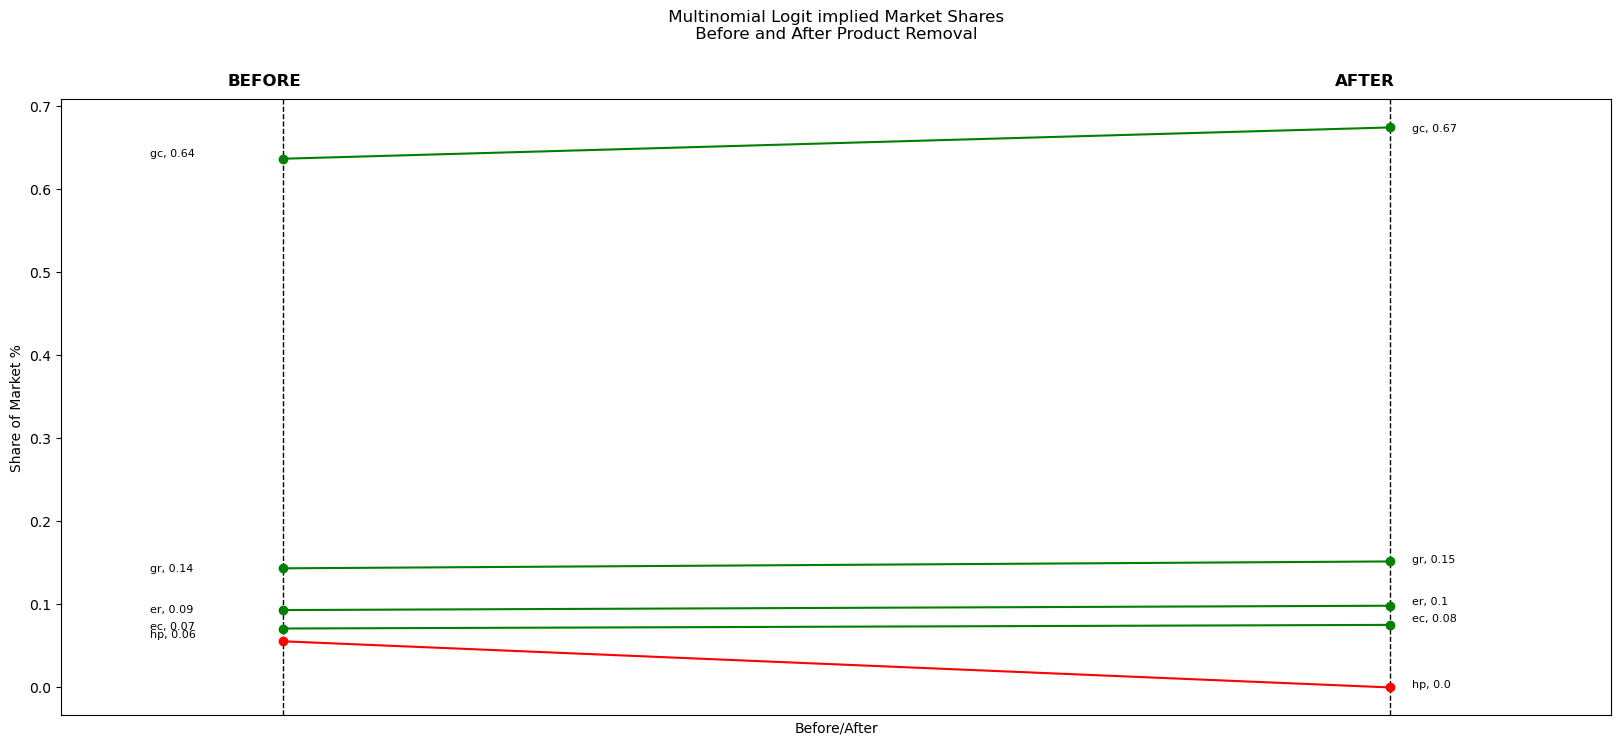

In [11]:
fig = mnl.make_change_plot(change_df, title="Product Removal", figsize=(20, 8))